# Emotion Classification in texts using Bi-Directional LSTM + CNN + FastText

### Architecture: 
(X) Text -> Embedding (FastText pretrained on wikipedia articles) -> Bi-Directional (Bi-LSTM) ->Feature Extraction (CNN 1D) -> Fully connected (Dense) -> Output Layer (Softmax) -> Emotion class (Y)

## Workflow: 
1. Import Data
2. Prepare the input data
3. Import pre-trained FastText
4. Create Neural Network Pipeline
5. Train The Model
6. Evaluate results

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Data


In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Bidirectional, LSTM, GRU, Dropout, Activation, TimeDistributed, Flatten, Concatenate

#Visualization
import seaborn as sns

Defining vector space dimension and fixed input size

In [2]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [3]:
data_train = pd.read_csv('data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [4]:
print(data.Emotion.value_counts())
data.head(6)

joy        2353
sadness    2304
neutral    2281
anger      2242
fear       2147
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


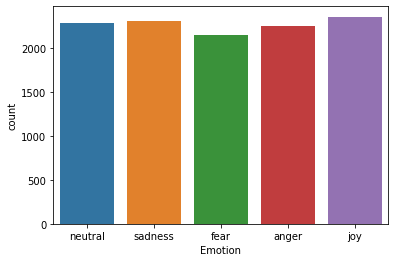

In [5]:
sns.countplot(data=data, x = 'Emotion')

## 2. Prepare input data
1. Tokenize texts and count unique tokens
2. Padding: each input (sentence or text) has to be of the same lenght
3. Labels have to be converted to integeres and categorized

In [6]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

*Making things easier for keras tokenizer 🙃

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [9]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


**Tokenization + fitting using keras**

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 10962


**Padding** -> each input has the same length

Defined maximun number of words for our texts and input size to our model has to be fixed - padding with zeros to keep the same input lenght

In [11]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,  106,   51,  418],
       [   0,    0,    0, ...,   40,  259,  156],
       [   0,    0,    0, ...,   16,    2, 1226],
       ...,
       [   0,    0,    0, ..., 1086,    4,  951],
       [   0,    0,    0, ...,    1,    6,  122],
       [   0,    0,    0, ..., 6411,  183,   13]], dtype=int32)

**Categorize** labels: 

In [12]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [13]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors.

* Importing pretrained FastText from file and creating embedding matrix
* Map each word in our corpus to existing word vector

In [14]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [15]:
import urllib.request
import zipfile
import os

fname = '/content/drive/MyDrive/Aznida_CNN/Word2Vec_FastText/wiki-news-300d-1M.vec'

In [16]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(10963, 300)

In [17]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 10400
New words found: 562


## 3. Create BiLSTM + CNN Pipeline

### Embedding Layer


In [18]:
# Embedding layer before the actual CNN
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline
- the input is the first N words of each text (with proper padding)
- the first level creates embedding of words, using vocabulary with a certain dimension, and a given size of embeddings
- Bi-Directional LSTM layer is to learn the previous info and 'remember'. 
- 1D convolutional neural network to extract features from data. The result of each convolution will fire when a special pattern is detected. 
- the output level has a number of neurons equal to the classes of the problem and a “softmax” activation function

In [19]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          3288900   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          439296    
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 256)          196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

## 3. Train the Model

In [22]:
batch_size = 256
epochs = 10

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/10
31/31 [==============================] - 371s 12s/step - loss: 1.4262 - accuracy: 0.3755 - val_loss: 1.1420 - val_accuracy: 0.5576
Epoch 2/10
31/31 [==============================] - 376s 12s/step - loss: 0.9901 - accuracy: 0.6281 - val_loss: 0.8387 - val_accuracy: 0.6905
Epoch 3/10
31/31 [==============================] - 363s 12s/step - loss: 0.7938 - accuracy: 0.7106 - val_loss: 0.7591 - val_accuracy: 0.7197
Epoch 4/10
31/31 [==============================] - 362s 12s/step - loss: 0.7337 - accuracy: 0.7334 - val_loss: 0.7083 - val_accuracy: 0.7495
Epoch 5/10
31/31 [==============================] - 365s 12s/step - loss: 0.6710 - accuracy: 0.7625 - val_loss: 0.6617 - val_accuracy: 0.7663
Epoch 6/10
31/31 [==============================] - 369s 12s/step - loss: 0.6171 - accuracy: 0.7802 - val_loss: 0.6299 - val_accuracy: 0.7798
Epoch 7/10
31/31 [==============================] - 367s 12s/step - loss: 0.5795 - accuracy: 0.7922 - val_loss: 0.6092 - val_accuracy: 0.7887
Epoch 

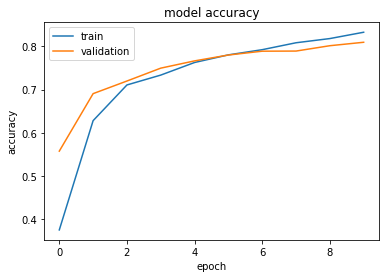

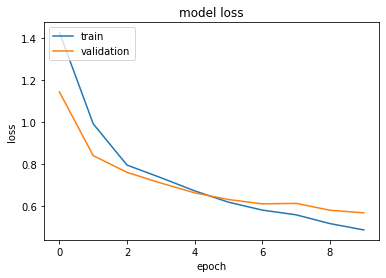

In [23]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. Evaluation

In [24]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [25]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 80.93%

F1 Score: 80.93


#### Plotting confusion Matrix:

#### Let's try other inputs:

In [26]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [27]:
import time

message = ['I have so many negative thoughts in my mind']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['I have so many negative thoughts in my mind']
predicted: sadness (0.13 seconds)


# Done
Save the model for later use 🙃 

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('models/cnn_lstm_fastText.h5')

In [ ]:
from keras.models import load_model
predictor = load_model('models/cnn_lstm_fastText.h5')

In [29]:
import time

message = ['I have so many negative thoughts in my mind']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['I have so many negative thoughts in my mind']
predicted: sadness (0.13 seconds)
